A*

In [476]:
from random import random
from functools import reduce
from collections import namedtuple
from queue import PriorityQueue

import numpy as np
import matplotlib.pyplot as plt

In [477]:
PROBLEM_SIZE = 20
NUM_SETS = 64
SETS = tuple(
    np.array([random() < 0.25 for _ in range(PROBLEM_SIZE)])
    for _ in range(NUM_SETS)
)
State = namedtuple('State', ['taken', 'not_taken'])

In [478]:
def goal_check(state):
    return np.all(reduce(
        np.logical_or,
        [SETS[i] for i in state.taken],
        np.array([False for _ in range(PROBLEM_SIZE)]),
    ))


def distance(state):
    return PROBLEM_SIZE - sum(
        reduce(
            np.logical_or,
            [SETS[i] for i in state.taken],
            np.array([False for _ in range(PROBLEM_SIZE)]),
        )) + len(state.taken)

In [479]:
assert goal_check(
    State(set(range(NUM_SETS)), set())
), "Probelm not solvable"

In [480]:
frontier = PriorityQueue()
state = State(set(), set(range(NUM_SETS)))
frontier.put((distance(state), state))

counter = 0
_, current_state = frontier.get()
while not goal_check(current_state):
    counter += 1
    for action in current_state[1]:
        new_state = State(
            current_state.taken ^ {action},
            current_state.not_taken ^ {action},
        )
        frontier.put((distance(new_state), new_state))
    _, current_state = frontier.get()

print(
    f"Solved in {counter:,} steps ({len(current_state.taken)} tiles)"
)

Solved in 5 steps (4 tiles)


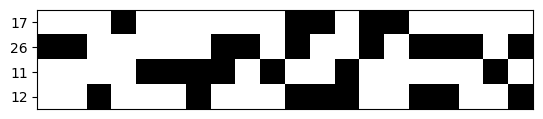

In [481]:
map = None
for i in current_state.taken:
    if map is not None:
        map = np.vstack((map, SETS[i]))
    else:
        map = SETS[i]

plt.imshow(map, cmap='binary')
ax = plt.gca()
ax.set_yticks(np.arange(len(current_state.taken)), current_state.taken)
ax.get_xaxis().set_visible(False)
plt.show;